<h1 align='center'>Ben Prescott - Assignment 4 Part 2</h1>

This notebook's first part focuses on leveraging the GloVe6B.100d embedding vectors to train a RNN, then using the RNN to predict the sentiment (positive or negative) of my test data. The second part uses my word embeddings generated in Part 1 to train an RNN (in comparison to using GloVe6B to train it) and using it to predict the sentiment of my test data. 

In [1]:
#Creating an interactive shell so that every output is visible, not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Importing Required Libraries

In [73]:
import numpy as np
import pandas as pd
import gc
from pickleshare import PickleShareDB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, GRU, LSTM, Bidirectional, LeakyReLU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.optimizers import Nadam
from plot_keras_history import plot_history
import scikitplot as skplt
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
#Defining the root directory for easier use late
root = 'C:/Users/bprescott/Documents/assignment-4/'
db4 = PickleShareDB(root+'/assign4.pshare')

## Loading All "X Data"

In [8]:
#Bringing in all of my X and y datasets
XTrain=db4['XTrain']
yTrain=db4['yTrain']
XVal=db4['XVal']
yVal=db4['yVal']
XTest = db4['XTest']
yTest = db4['yTest']
XTrainEm = db4['XTrainEm']
XValEm = db4['XValEm']
XTestEm = db4['XTestEm']

## Importing & Parsing GloVe.6B100d Word Vectors File

Here I'll be reading the GloVe6B.100d word embeddings vector file and adding each line into a list named emFil. Then for each line in the emFil list I'll split the values by space, take the first value in each line (the actual word itself), then separate off the embedding values into a NumPy array. Finally, I'll be adding the word and its embedding values to a key/value dictionary named emIndx. I removed the counter object from the loop, as there is no counting/incrementing being done.

In [24]:
#Adding the GloVe file to an object
GloVeFil=root+'GloVe/glove.6B.100d.txt'
#Creating the empty dictionary to store the GloVe key/value pairs
emIndx=dict()
#Opening the file. Utf-8 added due to errors
with open(GloVeFil, encoding='utf8') as inFile: 
    #Reading each line and adding to emFil list
    emFil=inFile.readlines()
#Creating a for loop
for line in emFil: #reading each line in the emFil list
    vals = line.split() #Splitting each line on spaces
    word = vals[0] #Grabbing the first value, which is always the actual word
    coefs = np.asarray(vals[1:],dtype='float32') #Separating the embedding values 
    emIndx[word]=coefs #Adding both the word and embedding values into emIndx dictionary

In [25]:
#Reviewing the number of vectors in the dictionary
print(f'number of vectors {len(emIndx)}')
#Reviewing an example of the length of a word + its embeddings
#This will be 101 as the word itself is not included in the total 100 dimensions
len(emFil[10].split())


number of vectors 400000


101

In [38]:
#Retreiving an example word from the dictionary to see its embeddings
emIndx['sup']

array([-0.30174  ,  0.049855 ,  0.64034  ,  0.083022 , -0.51203  ,
       -0.083351 , -0.3139   , -0.095166 ,  0.32351  ,  0.050411 ,
        0.55947  ,  0.066653 ,  0.090677 ,  0.15711  ,  0.13611  ,
       -0.30429  ,  0.79512  ,  0.62436  , -0.33637  , -0.71212  ,
        0.33704  ,  0.42167  , -0.070383 ,  0.21789  , -0.033818 ,
        0.33773  ,  0.017364 , -0.16595  , -0.27797  ,  0.5284   ,
        0.02127  ,  0.2997   , -0.38149  ,  0.079488 , -0.068081 ,
       -0.52259  ,  0.43309  , -0.29571  ,  0.051077 , -0.29229  ,
       -0.46897  , -0.0032661, -0.35951  , -0.48593  ,  0.3625   ,
       -0.10928  , -1.0337   , -0.29318  ,  0.24471  ,  0.51143  ,
       -0.52875  , -0.17947  ,  0.30718  , -0.153    , -0.058011 ,
        0.76466  ,  0.4227   ,  0.76374  , -0.20999  , -0.63872  ,
       -0.82858  , -0.18816  , -0.44086  , -0.002028 , -0.81503  ,
        0.50289  ,  0.85958  ,  0.32821  , -0.36141  ,  0.38538  ,
        0.01855  , -0.042568 , -0.31175  , -0.66004  ,  0.1554

## Pretrained Sentiment Analysis - Subpart A

In order to use our review data in the second RNN we'll need to convert our words into an embedding matrix. We'll be keeping with the same hyperparameters to keep with the 10000 by 100 matrix.

### Setup and Import Training/Validation Words

In [47]:
#Assigning the training/validation data words to an object for use
wordIndx=db4['wordIndx'] 
wordIndx['hey'] #Example number corresponding to the word "hey"

1398

In [48]:
type(wordIndx) #Viewing the type.
len(wordIndx) #Viewing how many words exist in the dictionary

dict

88582

### Create Matrix of Embedding Weights 

In this section I'll be converting the vectors into a matrix of 10000 rows by 100 columns. We first need to create an empty matrix with the proper dimensions. The command `np.zero` will allow us to do that, using the maxWords and emDim objects as rows and columns. 

First, we'll reset those to ensure we're working with the correct numbers.

In [49]:
maxWords=10000 #Keeping the same as the initial pre-processing maxWords
emDim=100 #Number of dimensions in the GloVe.6b.100d set
maxLen=80 #Keeping the same maxLen as in Part 1

In [56]:
emMat=np.zeros((maxWords,emDim)) #Create empty matrix of 10000x100 with all zeros

for word, i in wordIndx.items(): #Iterate over the keys/values in our training/val dictionary
    if i < maxWords: #Iterate until number associated with a word meets our maxWords setting
        emVec = emIndx.get(word)  #Gets the GloVe embedding associated with the word
        if emVec is not None: #As long as the response isnt 'none'...
            emMat[i]=emVec #Add the embedding to the matrix

In [72]:
print("emMat object type:",type(emMat)) #object type for emMat
print("emMat shape:",emMat.shape,'\n') #Matrix shape
print("Using the word 'the': Key Number",wordIndx['the']) #Finding the # from our dictionary
emMat[1] #GloVe embedding for the word "the"

emMat object type: <class 'numpy.ndarray'>
emMat shape: (10000, 100) 

Using the word 'the': Key Number 1


array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

In [31]:
#Saving the new embedding weight matrix as a file
db4['emMat10000X100']=emMat

### Defining The RNN

Now that we have our embedding matrix we'll be defining and training a RNN to predict sentiment of our test data. I'll be using the Keras Sequential API to define the model architecture and applying our 10000 x 100 embedding matrix as weights for the Embedding layer.

In [167]:
clear_session() #clearing all previous model information
gc.collect() #freeing up memory

115

In [168]:
#Using the Sequential API to build our model
model = Sequential()
#Creating our embedding layer using the hyperparameters defined above
model.add(Embedding(maxWords,emDim,input_length=maxLen))
#Leveraging bidirectional GRU layers that act like LSTM layers, but fewer parameters due to lacking an output gate. 
model.add(Bidirectional(GRU(100, return_sequences=True)))
#Using LeakyReLU layers to help avoid exploding gradients
model.add(LeakyReLU())
#Using another bidirectional GRU layer to serve as the "bottleneck"  
model.add(Bidirectional(GRU(50, return_sequences=True)))
#Another LeakyReLU for managing exploding gradients
model.add(LeakyReLU())
#A final bidirectional GRU layer with the original number of nodes to force an "upscaling" from the bottleneck. Also including L2 regularization
model.add(Bidirectional(GRU(100, kernel_regularizer=l2(0.01))))
#Our final Dense layer with a single output node to predict a number between 0 and 1
model.add(Dense(1,activation='sigmoid'))

In [169]:
#Creating the model summary to see how our sequential model is structured. 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 80, 100)           1000000   
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 200)           121200    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 80, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 100)           75600     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               121200    
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [170]:
#Adding our embedding matrix as weights to the Embedding layer
model.layers[0].set_weights([emMat])
#Ensuring this layer doesn't learn the weights on its own
model.layers[0].trainable=False 

In [171]:
#Embedding matrix weights for second item #1
emMat[1]
#Comparing the assigned weights for the first node
model.layers[0].get_weights()[0][1] 

array([-0.038194  , -0.24487001,  0.72812003, -0.39961001,  0.083172  ,
        0.043953  , -0.39140999,  0.3344    , -0.57545   ,  0.087459  ,
        0.28786999, -0.06731   ,  0.30906001, -0.26383999, -0.13231   ,
       -0.20757   ,  0.33395001, -0.33848   , -0.31742999, -0.48335999,
        0.1464    , -0.37303999,  0.34577   ,  0.052041  ,  0.44946   ,
       -0.46970999,  0.02628   , -0.54154998, -0.15518001, -0.14106999,
       -0.039722  ,  0.28277001,  0.14393   ,  0.23464   , -0.31020999,
        0.086173  ,  0.20397   ,  0.52623999,  0.17163999, -0.082378  ,
       -0.71787   , -0.41531   ,  0.20334999, -0.12763   ,  0.41367   ,
        0.55186999,  0.57907999, -0.33476999, -0.36559001, -0.54856998,
       -0.062892  ,  0.26583999,  0.30204999,  0.99774998, -0.80480999,
       -3.0243001 ,  0.01254   , -0.36941999,  2.21670008,  0.72201002,
       -0.24978   ,  0.92136002,  0.034514  ,  0.46744999,  1.10790002,
       -0.19358   , -0.074575  ,  0.23353   , -0.052062  , -0.22

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

### Training The RNN

Now that we have our RNN architecture defined, and our embedding matrix weights added to the Embedding layer, we're going to move into training the model. We'll be sticking with the Nadam optimizer with a learning rate of 0.0001. We'll also be using binary_crossentropy for our measure of loss, as this RNN is predicting a sentiment score.

However, we'll also be implementing a callback called `ReduceLROnPlateau` that if theres no improvement in 2 epochs it will start dropping the learning rate further to hope to improve  performance.

In [172]:
#Compiling the model using Nadam optimizer, LR of 0.0001, bi
model.compile(
    optimizer=Nadam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['acc']
    )

In [173]:
#Callback for early stopping to help avoid overfitting
callback=EarlyStopping(monitor='val_loss',patience=3)
#Callback to reduce learning rate if the validation loss plateaus
ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
#Training the model using XTrain and yTrain data. 
history=model.fit(XTrain, yTrain,
        epochs=20,
        batch_size=32,
        validation_data=(XVal,yVal),
        verbose=0,
        callbacks=[callback,ReduceLR])
model.save_weights('assign-8-pretrained-test-1.h5') #saving the weights in a file for later use

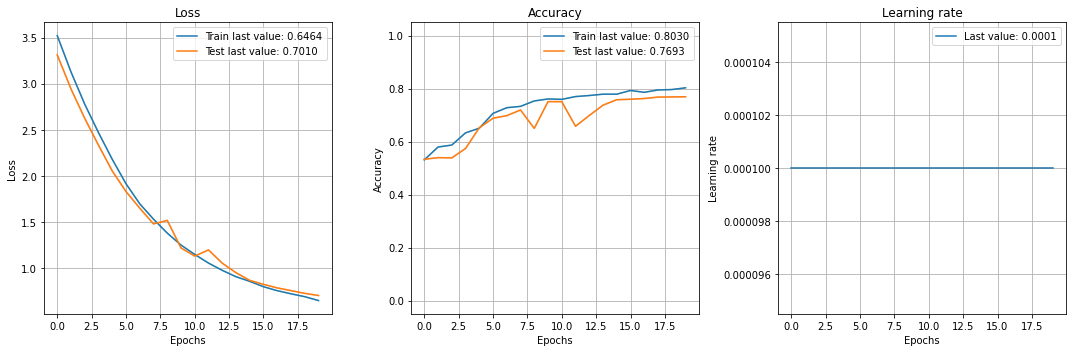

In [174]:
#Reviewing model performance
plot_history(history.history)

In [175]:
#Creating a dataframe of the model results over each epoch
resDF=pd.DataFrame(history.history)
print(resDF[['acc','val_acc','loss','val_loss']])

       acc   val_acc      loss  val_loss
0   0.5310  0.533333  3.520948  3.311956
1   0.5795  0.539500  3.126711  2.942350
2   0.5870  0.538500  2.776290  2.622745
3   0.6330  0.574000  2.468375  2.331643
4   0.6505  0.652167  2.178781  2.052366
5   0.7065  0.688167  1.914116  1.829097
6   0.7280  0.698000  1.695940  1.648740
7   0.7330  0.719333  1.529744  1.478397
8   0.7535  0.649833  1.378392  1.516268
9   0.7610  0.751000  1.248687  1.217357
10  0.7595  0.750833  1.146855  1.128702
11  0.7700  0.657833  1.052992  1.195958
12  0.7740  0.698667  0.974239  1.051958
13  0.7790  0.737500  0.904876  0.948627
14  0.7790  0.758167  0.854709  0.865114
15  0.7930  0.759833  0.796448  0.822112
16  0.7860  0.762667  0.753599  0.783777
17  0.7950  0.768000  0.719650  0.754151
18  0.7965  0.768667  0.688507  0.724431
19  0.8030  0.769333  0.646373  0.701008


### Model Performance

Now that we have our pretrained embedding model performing decently, we'll use it to predict the sentiment of our XTest dataset. Considering this is a binary classification problem we'll be using a confusion matrix, precision-recall curve, and ROC curve to visualize the performance of our models.

In [177]:
#Predicting the probability of 0 or 1 using the XTest dataset.
testprob = model.predict(XTest) 
testprobcon = np.concatenate((1-testprob,testprob),axis=1)

In [228]:
(testprobcon>.5).astype(int)
yTest

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

array([1, 1, 1, ..., 1, 1, 0])

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

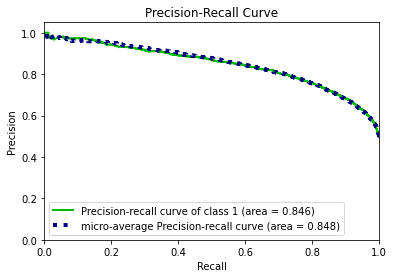

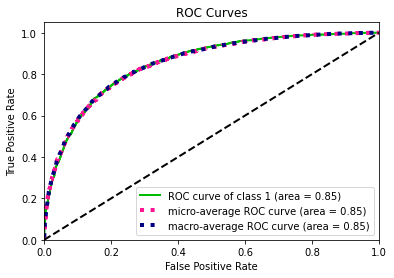

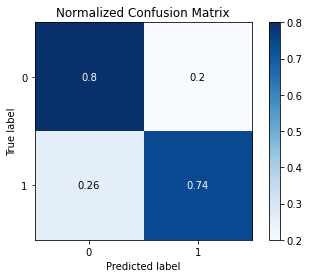

In [229]:
#Plotting a precision-recall curve
skplt.metrics.plot_precision_recall(yTest,testprobcon,classes_to_plot=[1])
#Plotting a ROC curve
skplt.metrics.plot_roc(yTest,testprobcon,classes_to_plot=[1]);
#Plotting a confusion matrix
skplt.metrics.plot_confusion_matrix(yTest, (testprob>.5).astype(int),normalize=True)

## Generated Sentiment Prediction - Subpart B

This section will be similar to the last, but using the XTrainEm and XValEm data to train the model. These are the data from our embeddings from Part 1 and do not use the GloVe embeddings. This will require our model to attempt to learn the weights itself.

**Unfortunately, I could not get this model to perform well. Regardless of how I adjusted hyperparameters, layers, neurons, etc. the model wouldn't learn using the XTrainEm and XValEm data. I'm not sure if I'm doing something wrong or not.**

In [245]:
clear_session() #clearing all previous model information
gc.collect() #freeing up memory

38567

We are following a similar model to the one created for the GloVe embeddings, with slightly different dimensions and lengths. The dimensions were changed due to the XTrainEm dataset being a 64 dimension dataset. The maxLen hyperparameter was also changed in an effort to find some way to gain improvement from the model.

In [246]:
maxWords = 10000 #Defining max words to use
emDim = XTrainEm.shape[1] #Defining the dimensions from the XTrainEm shape
maxLen = 64 #Setting maxLen to 64 from 80. This was changed in an effort to see if different settings would result in different model performance.

#Leveraging the Sequential API
model2 = Sequential()
#Creating an embedding layer using our hyperparameters
model2.add(Embedding(maxWords,emDim,input_length=maxLen))
#Leveraging bidirectional GRU layers that act like LSTM layers, but fewer parameters due to lacking an output gate. 
model2.add(Bidirectional(GRU(64, return_sequences=True)))
#Using LeakyReLU layers in hopes to avoid exploding gradients
model2.add(LeakyReLU())
#Adding a second bidirectional GRU layer with fewer nodes to force a bottleneck
model2.add(Bidirectional(GRU(32, return_sequences=True)))
#Another LeakyReLU for managing exploding gradients
model2.add(LeakyReLU())
#Using a 64 node bidirectional GRU layer to "upscale" to the original shape prior to our final dense layer. Also adding regularization as to not use another LeakyReLU layer. 
model2.add(Bidirectional(GRU(64, kernel_regularizer=l2(0.01))))
#Dense layer with one output node to return a number between 0 and 1
model2.add(Dense(1,activation='sigmoid'))

In [247]:
#Creating the model summary to see how our sequential model is structured. 
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 64)            640000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 128)           49920     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64, 64)            31104     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               49920     
_________________________________________________________________
dense (Dense)                (None, 1)                 1

In [248]:
#Compiling the model, sticking with Nadam optimizer and learning rate of 0.0001 
#Continuing to use binary crossentropy loss measure as the result is binary.
model2.compile(
    optimizer=Nadam(lr=0.0001),
    loss='binary_crossentropy',
    metrics=['acc']
    )

In [ ]:
#Using the same callbacks as our GloVe NN as a way to avoid overfitting and also help adjust the Nadam learning rate dynamically
callback=EarlyStopping(monitor='val_loss',patience=3)
ReduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)

#Fitting the model. Multiple attempts were made to find any increase in performance, but with no luck.
history2=model2.fit(XTrainEm, yTrain,
        epochs=5,
        batch_size=32,
        validation_data=(XValEm,yVal),
        verbose=0,
        callbacks=[callback,ReduceLR])
model2.save_weights('assign-8-trained-test-1.h5')

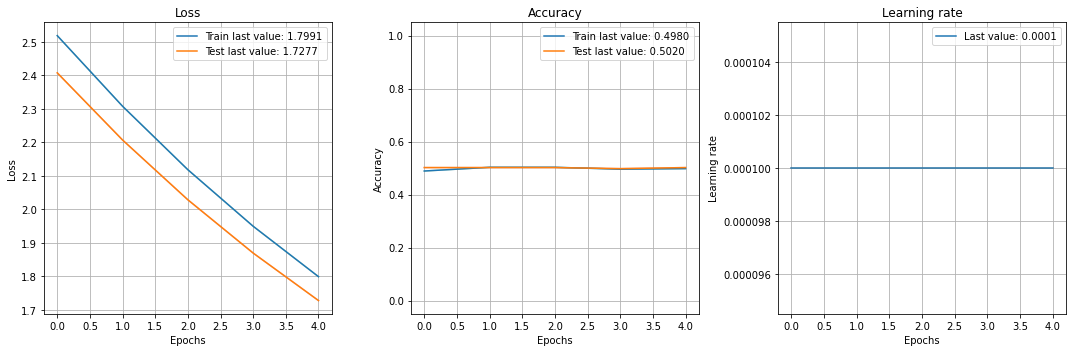

In [250]:
#Plotting the model results
plot_history(history2.history)

## Conclusion

The RNN trained using the GloVe embeddings seemed to achieve "ok" performance after tuning and tweaking it a bit. One of the biggest struggles was managing the fluctuation in validation loss, exploding gradients, and the model trying to overfit. The current performance looks to be pretty good, but my intuition tells me this model should perform better considering the embeddings we're using. 

The second RNN not using the GloVe embeddings as weights started to cause some mild insanity. I attempted many different architectures and hyperparameters with no real cahnge in model performance. I've noticed the loss continues to drop but accuracy remains consistent at 50/50. My hunch is that I may have missed a step or didn't fully understand the use of the Part 1 embeddings in this model. I will be continuing to work with this to see if I can find where I went wrong, but for comparison's sake the GloVe RNN is the clear winner of the two. 